# 演習1-1 

## 回帰問題編

わからない場合や方針が立たない場合は PracticeHint にある同名のファイルを眺めてみてください．

In [1]:
import numpy as np
import matplotlib.pylab as plt

直線のモデル y = a x + b を考える．
データは，直線モデルから，ノイズが加えられて観測したとする．
このときのノイズの標準偏差は sgm = 0.2 とする

In [2]:
# ここらへんのパラメータを変えて遊んでみてください

N = 1000  #サンプル点の個数
a = 0.5  #モデル直線の傾き
b = 0.8  #モデル直線の切片
sgm = 0.05
# ノイズの標準偏差

x = np.random.rand(N)    # [0, 1) の区間に N 個の乱数発生
ytrue = a * x + b

y = ytrue  + sgm * np.random.randn(N)  # 真値にノイズを乗せて観測データを作る

### これで下準備完了
(x, y) にデータが入っている．これのプロットと真の直線の関係を見てみる

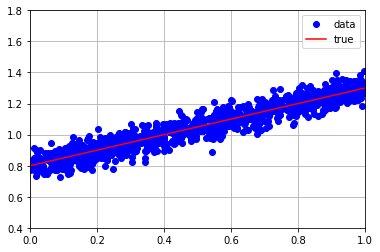

In [3]:
plt.plot(x, y, 'bo', label='data')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0.4, 1.8)
xx = np.linspace(0, 1, 128)
yy = a * xx + b
plt.plot(xx, yy, 'r-', label='true')
plt.legend()

## 問い: データ点（青い点）のみから，もとになる直線（赤直線）を推定することは可能か？

データの点群を $\{(x_n, y_n)\}$ とし， 推定モデルを $f(x; w) = w_1 x + w_0$ とおいて， $w_0$ と $w_1$ を推定することを考える．
この問題は *最小二乗法* の問題で，　以下の関数（ロス関数と呼ばれる）
$$
    J(w) = \frac{1}{N} \sum_n (y_n - f(x_n))^2
$$
を，最小化する　$w$ を求めることを考える． 

## 要はモデル $f(x_n)$ と，　観測点 $y_n$ の差（残差）が小さくなる $w$ を求める．


この問題は，正規方程式
$$
    \left(\begin{array}{rr} N & \sum x_n \\ \sum x_n  & \sum x_n^2 \end{array}\right) 
    \left(\begin{array}{r} w_0 \\ w_1 \end{array}\right)
    =
     \left(\begin{array}{r} \sum y_n \\ \sum x_n y_n \end{array}\right)
$$
を解けばよい（導出が知りたければ質問すること）．
解は，
$$
    \left(\begin{array}{r} w_0 \\ w_1 \end{array}\right)
    =
    \frac{1}{N \sum x_n^2 - (\sum x_n)^2}
    \left(\begin{array}{rr} \sum x_n^2  & - \sum x_n \\ - \sum x_n  & N\end{array}\right) 
     \left(\begin{array}{r} \sum y_n \\ \sum x_n y_n \end{array}\right)
$$

In [4]:
# 最小二乗法から解をもとめよ
# とりあえず，和記号のついたやつから求めたらいいんじゃないかな？
# で，それを使って階を計算するってことで
xsum = x.sum()
xsum2 = (x**2).sum()
ysum = y.sum()
xysum = x@y
mo = N*xsum2-(xsum)**2
w0 = (xsum2*ysum-xsum*xysum)/mo
w1 = (N*xysum-xsum*ysum)/mo

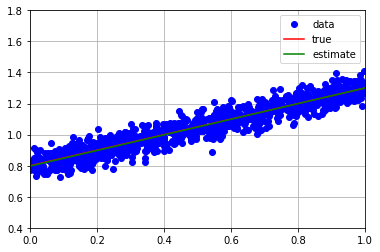

In [5]:
# 得られた直線が正しそうか プロット してみよ
plt.plot(x, y, 'bo', label='data')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0.4, 1.8)

xx = np.linspace(0, 1, 128)
yy = a * xx + b
plt.plot(xx, yy, 'r-', label='true')
yy = w1 * xx + w0
plt.plot(xx, yy, 'g-', label='estimate')
plt.legend() # 凡例を描画

ついでに，残差とロス関数値も評価しておこう．　残差は モデル $f(x) = w_1 x + w_0$ が吐き出す予測値と $y$ の差の総和

In [6]:
# 残差を表示せよ
residual = np.sum((y-(w1*x+w0))**2)
print( "Residual: %.3f" % (residual))
print( "Mean squared error %.3f" % (residual/N))   #1点あたりのズレ（平均二乗誤差）

Residual: 2.431
Mean squared error 0.002



## Keras + Tensorflow を用いて答えを求めなさい

TensorFlow は，　Google が開発した深層学習要の枠組み（フレームワーク）です．
これだけでも慣れれば使えるけど，ややマニアックな習性があるので，
それを噛み砕いたインターフェースが Keras だとおもってもらってよいです．
（誤解をおそれずにいえばです
公式ドキュメントは→ https://keras.io/ja/

In [7]:
# Keras を用いて実現せよ
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

回帰モデルは　$f(x; w) = w_1 x + w_0$ となり，パラメータは $w_1$ と $w_0$ な形で表されます．
これを計算グラフと呼ばれる表現（ニューラルネットワーク表現）であらわすと，入力 $x$ に対して
重み $w_1$ をかけ，バイアスとして $w_0$ を足したものを出力とするユニットを造ればよいということになります．

モデルを構築するための枠組みとしては，入力を変換して別形式にする `Sequential` モデルを使います．(https://keras.io/ja/getting-started/sequential-model-guide/)
この `Sequential` モデルの上に，入力が `x` 一つで，バイアス($w_0$)ありのモデルを `add` することでモデルを構築します．

さらにこのモデルにたいして，どのようなロス関数を用いて最適化を行うかを指定します．
ロス関数は上述の二乗誤差で良いはずなので `model.fit()` 関数の `loss` パラメータに `'mean_squared_error'` を指定します． 
最適化に関してもいろいろ選べますが，ここでは天下り的に確率的勾配降下法（Stochastic Gradient Decent）を使います．
これは `model.fit()` を呼び出す際に`optimizer` パラメータに `'sgd'` を指定してやるだけです．
（細かい調整もできますが，ここでは雰囲気をつかむということで）

In [8]:
# 記述としてやることは 
# 1. model を Sequential クラスのインスタンスとしてつくり
#    model = Sequential()
# 2. model に出力 w1 x + w0 を計算するユニットを add する．
#  　（この場合入力は x で，w0, w1 がパラメータとなる，1個のユニットを加えるだけ）
#    model.add(Dense(1, input_shape=(1,), use_bias=True))
#    Dense(1, input_shape=(1,), use_bias=True) は入力側の重み付き和を計算するユニット
# 3. model をデータ x, y に fit させるです．
#    model.compile(loss='mean_squared_error', optimizer='sgd')
# となります．loss はロス関数の形を表し，自前で定義してもよいのですが，'mean_squared_error' を指定すると
# 平均二乗誤差を内部でとってくれます．optimizer は標準的な確率降下法(Stochastic Gradient Decent)を指定しています．
#  具体的な記法がわからなければ PracticeHint/ へ
# 

# 以下にコードを書いていくこと（写経でもよいので，書いて動かしてみることは重要）
model = Sequential()   
model.add(Dense(1, input_shape=(1,), use_bias=True)) 
model.compile(loss='mean_squared_error',  optimizer='sgd') 
hist = model.fit(x,y,epochs=1024,batch_size=50,verbose=1)

2022-01-26 10:01:22.705035: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.5177
Epoch 2/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.1883
Epoch 3/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0703
Epoch 4/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0281
Epoch 5/1024
20/20 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 6/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0076
Epoch 7/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 8/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch 9/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 10/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 11/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0041
Epoch 12/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0040
Epoch 13/1024
20/20 [====

Epoch 101/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 102/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 103/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 104/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 105/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 106/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 107/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 108/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 109/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 110/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 111/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 112/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoc

20/20 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 298/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 299/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 300/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 301/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 302/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 303/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 304/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 305/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 306/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 307/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 308/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 309/1024
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 494/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 495/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 496/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 497/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 498/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 499/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 500/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 501/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 502/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 503/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 504/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 505/1024
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 690/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 691/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 692/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 693/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 694/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 695/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 696/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 697/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 698/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 699/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 700/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 701/1024
20/2

20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 886/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 887/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 888/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 889/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 890/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 891/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 892/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 893/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 894/1024
20/20 [==============================] - 0s 2ms/step - loss: 0.0024
Epoch 895/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 896/1024
20/20 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 897/1024
20/2

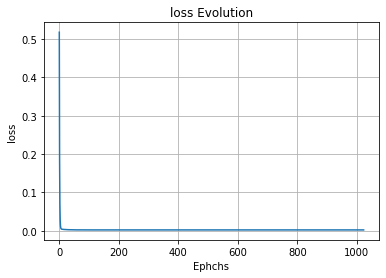

In [9]:
# ロスの値が学習によってどう変わっていくのかを表示すること
# 以下にコードを書いていくこと

plt.plot(hist.history["loss"])
plt.title("loss Evolution")
plt.xlabel("Ephchs")
plt.ylabel("loss")
plt.grid()

w0, w1 = (0.797, 0.503)


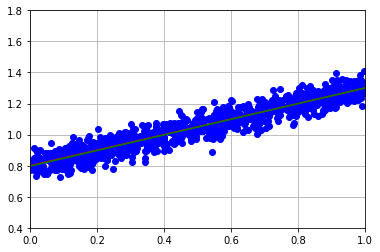

In [10]:
# 推定直線とデータ，真の直線をグラフとして重ねて表示してみなさい
#w0 と w1 は，　np.array なので，使いやすいように float 型へ変換しておく
w1, w0 = model.get_weights()
print( "w0, w1 = (%.3f, %.3f)" % (w0, w1))
w0 = float(w0)
w1 = float(w1)

# あとはプロット
plt.plot(x, y, 'bo')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0.4, 1.8)

xx = np.linspace(0, 1, 128)
yy = a * xx + b
plt.plot(xx, yy, 'r-')
yy = w1 * xx + w0
plt.plot(xx, yy, 'g-')

## 考察
epochs=512では、真の直線と平均20度くらいのズレがあり、epochs=1024では平均5度くらいのズレがあった。その後、epochs=2048,4096でも実行したが、あまり変わらなかった。このことから、どのような場合でもおよそepochs=1024で収束するのだと考えられる。
収束条件をepoch数20で0.001以上変わらないこととし、収束するまでのepoch数を調べた。ただし、epochとlossの値は5回計測したものの平均である。sgm=0.02でepoch=150,loss=0.007,sgm=0.03でepoch=538,loss=0.018,sgm=0.04でepoch=722,loss=0.028,sgm=0.05でepoch=856,loss=0.03となった。このことから、epoch数の上昇が徐々に少なくなっていることがわかる。よって、収束に必要なepoch数も収束しているのだと考えられる。直線の傾きを0.5,y切片を0.8にした。また、直線の傾きをさらに1,0.25としてみたが特に変化はなかった。最後にサンプル数を1000まで100ずつ増やして変遷を見たが、epoch数を増やすより効率的に性能を上昇させることができた。最終的に、y切片と傾きの誤差を0.003ニスることができた。ただ、200ぐらいで既に同じような収束の形になっていたし、処理を終了させるのに10分ぐらいかかった。以上より、収束速度や学習の精度に関係あるのは、epoch数と標準偏差、データ数であると考えらえる。ただし、学習回数やデータが増えれば精度が上がるのは当たり前であるし、標準偏差が小さいということは直線とのずれが小さいということだから、この結果は当たり前ではあると考えられる。